In [2]:
% matplotlib inline

import logging
import sys

from neural_metrics import run as run_metrics

logging.basicConfig(stream=sys.stdout, level=logging.getLevelName("WARNING"))


def run(*args, **kwargs):
    scores = run_metrics(*args, **kwargs)
    for score in scores:
        print("{} explanation: {}".format(score.name, score.explanation))


Using TensorFlow backend.


In [3]:
from neural_metrics.metrics.physiology.noise_ceiling import noise_ceiling as ceiling

noise_ceiling = 0.6793499237826475  # ceiling()

#### Standard models

In [4]:
from neural_metrics import models
from neural_metrics.metrics import score_model_activations

model_val_top5_errors = {
    'alexnet': 19.8,
    'vgg16': 8.8,
    'resnet50': 5.25,
    'inception_v3': 4.2,
    'densenet': 6.66,
}

model_val_top1_errors = {
    'alexnet': 37.5,
    'vgg16': 24.4,
    'resnet50': 22.85,
    'inception_v3': 18.77,
    'densenet': 23.61,
}

standard_model_scores = {}
for model in ['alexnet', 'vgg16', 'resnet50', 'inception_v3', 'densenet']:
    print("Scores for {}".format(model))
    activations_savepath = models.get_savepath(model)
    scores = score_model_activations(activations_savepath, ['V4', 'IT'])
    standard_model_scores[model] = scores

Scores for alexnet
Scores for vgg16
Scores for resnet50
Scores for inception_v3
Scores for densenet


#### Basenets

In [5]:
import glob
import os
import pickle
from collections import defaultdict

import numpy as np

with open('basenets_top1.pkl', 'rb') as f:
    _basenet_performances = pickle.load(f)
basenet_performances = defaultdict(list)
for (name, epochs), score in _basenet_performances.items():
    basenet_performances['{}--{}'.format(name, epochs)].append(score)
basenet_performances = {name: np.mean(scores) for name, scores in basenet_performances.items()}

basenets_scores = {}
for activations_savepath in glob.glob('images/sorted/basenet*-scores.pkl'):
    activations_savepath = activations_savepath.replace('-scores', '')
    basenet_name = os.path.basename(activations_savepath).split('-weights')[0]
    scores = score_model_activations(activations_savepath, ['IT'])
    assert len(scores) == 1
    if basenet_name not in basenet_performances:
        print("Ignoring {} (not in performances)".format(basenet_name))
        continue
    performance = basenet_performances[basenet_name]
    basenets_scores[performance] = scores[0]


Ignoring basenet6_100_0--40006 (not in performances)
Ignoring basenet6_100_0--80001 (not in performances)


In [6]:
def get_score(scores, name, get_y=True):
    return next(score.y if get_y else score for score in scores if score.name == name)

def get_scores(scoress, name, get_y=True):
    return [get_score(scores, name, get_y=get_y) for scores in scoress]

plot_properties = {
    'V4': dict(marker='o', markersize=15, color='green'),
    'IT': dict(marker='^', markersize=15, color='blue')
}


## IT curve

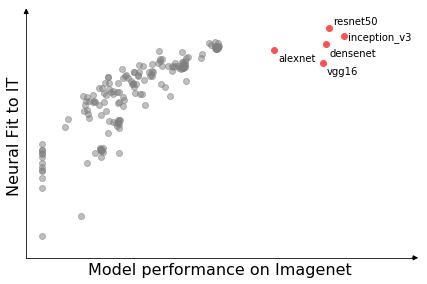

In [20]:
from matplotlib import pyplot
from neural_metrics.plot import arrowed_spines

pyplot.scatter([100 * performance for performance in basenets_scores.keys()],
               [score.y for score in basenets_scores.values()], color='gray', alpha=0.5)
for model, values in standard_model_scores.items():
    x, y = 100 - model_val_top1_errors[model], get_score(values, 'IT')
    pyplot.scatter(x, y, color='#FF5154')
    pyplot.text(x + 1, y - (0.005 if model == 'inception_v3' else -0.005 if model == 'resnet50' else 0.015), model)

# pyplot.plot(pyplot.xlim(), [noise_ceiling, noise_ceiling], 'k--')
# pyplot.text(0, noise_ceiling * 0.97, 'noise ceiling')

for spine in ['top', 'right']:
    pyplot.gca().spines[spine].set_visible(False)

arrowed_spines()
pyplot.gca().xaxis.set_ticks([])
pyplot.gca().yaxis.set_ticks([])
pyplot.xlim([pyplot.xlim()[0], 100])
# pyplot.gca().yaxis.set_label_position('right')
pyplot.xlabel("Model performance on Imagenet", fontsize=16)
pyplot.ylabel("Neural Fit to IT", fontsize=16)
pyplot.tight_layout()
pyplot.savefig('results/performance-v-fit.svg', transparent=True)


## V4 vs IT

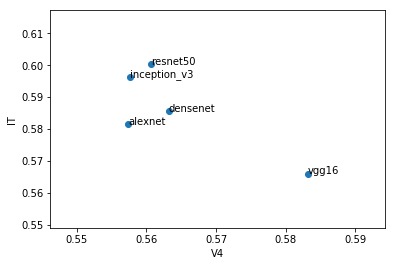

In [40]:
from matplotlib import pyplot

pyplot.scatter(get_scores(standard_model_scores.values(), 'V4'), get_scores(standard_model_scores.values(), 'IT'))
pyplot.xlabel('V4')
pyplot.ylabel('IT')
for model, scores in standard_model_scores.items():
    pyplot.text(get_score(scores, 'V4'), get_score(scores, 'IT'), model)


Text(0,0.5,'V4 / IT score')

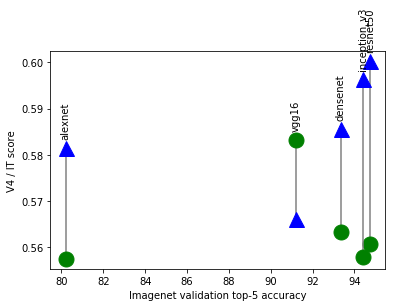

In [42]:
from matplotlib import pyplot

for model, scores in standard_model_scores.items():
    performance = 100 - model_val_top5_errors[model]
    pyplot.plot(2 * [performance], [get_score(scores, 'V4'), get_score(scores, 'IT')], color='gray')
    pyplot.plot(performance, get_score(scores, 'V4'), **plot_properties['V4'])
    pyplot.plot(performance, get_score(scores, 'IT'), **plot_properties['IT'])
    pyplot.text(performance, max(get_score(scores, 'V4'), get_score(scores, 'IT')) + 0.002, model,
                rotation='vertical', verticalalignment='bottom', horizontalalignment='center')
pyplot.xlabel('Imagenet validation top-5 accuracy')
pyplot.ylabel('V4 / IT score')


Text(0,0.5,'V4 / IT score')

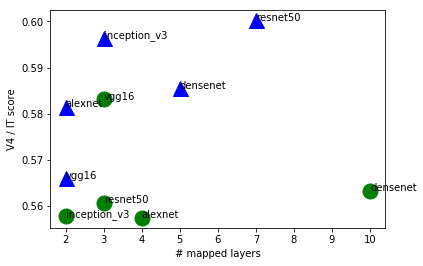

In [43]:
for model, scores in standard_model_scores.items():
    for region in ['V4', 'IT']:
        score = get_score(scores, region, get_y=False)
        num_layers = len(score.explanation)
        pyplot.plot(num_layers, score.y, **plot_properties[region])
        pyplot.text(num_layers, score.y, model)
pyplot.xlabel('# mapped layers')
pyplot.ylabel('V4 / IT score')


## Single Models

### Alexnet

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/alexnet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> features.2,features.5,features.7 (0.56), IT -> features.9,features.12,classifier.2,classifier.5,classifier.6 (0.58)


INFO:neural_metrics:Plotting


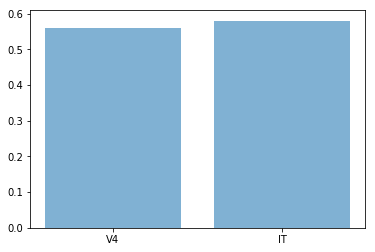

V4 explanation: ['features.2', 'features.5', 'features.7']
IT explanation: ['features.9', 'features.12', 'classifier.2', 'classifier.5', 'classifier.6']


In [3]:
run(model='alexnet', layers=['features.2', 'features.5', 'features.7', 'features.9', 'features.12', 
                             'classifier.2', 'classifier.5', 'classifier.6'])

### VGG16

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/vgg16-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> block1_pool,block2_pool,block3_pool (0.58), IT -> block4_pool,block5_pool,fc1,fc2 (0.57)


INFO:neural_metrics:Plotting


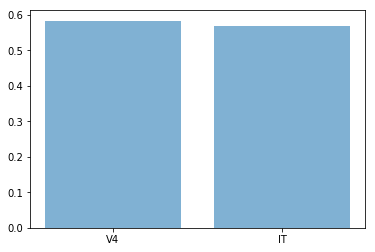

V4 explanation: ['block1_pool', 'block2_pool', 'block3_pool']
IT explanation: ['block4_pool', 'block5_pool', 'fc1', 'fc2']


In [5]:
run(model='vgg16', layers=['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 
                           'fc1', 'fc2'])

In [6]:
run(model='vgg16', layers=['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 
                           'fc1', 'fc2'],
    model_weights=None)

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models.outputs:Computing layer outputs


KeyboardInterrupt: 

### ResNet50

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/resnet50-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,activation_10,activation_11,activation_12,activation_13,activation_14,activation_15,activation_16,activation_17,activation_18,activation_19,activation_20,activation_21,activation_22,activation_23,activation_24,activation_25,activation_26,activation_27,activation_28 (0.57), IT -> activation_29,activation_30,activation_31,activation_32,activation_33,activation_34,activation_35,activation_36,activation_37,activation_38,activation_39,activation_40,activation_41,activation_42,activation_43,activation_44,activation_45,activation_46,activation_47,activation_48,activation_49 (0.61)


INFO:neural_metrics:Plotting


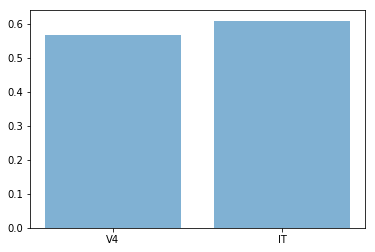

V4 explanation: ['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28']
IT explanation: ['activation_29', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 'activation_46', 'activation_47', 'activation_48', 'activation_49']


In [7]:
run(model='resnet50', layers=['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 
                              'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 
                              'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 
                              'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 
                              'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 
                              'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_30', 
                              'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 
                              'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 
                              'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 
                              'activation_46', 'activation_47', 'activation_48', 'activation_49'])

### ResNet152

In [ ]:
run(model='resnet152', layers=['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 
                           'fc1', 'fc2'])

### InceptionV3

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/inception_v3-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> mixed0,mixed1,mixed2,mixed3 (0.55), IT -> mixed4,mixed5,mixed6,mixed7,mixed8,mixed9,mixed10 (0.59)


INFO:neural_metrics:Plotting


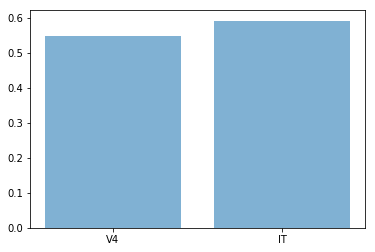

V4 explanation: ['mixed0', 'mixed1', 'mixed2', 'mixed3']
IT explanation: ['mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9', 'mixed10']


In [8]:
run(model='inception_v3', layers=['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 
                                  'mixed6', 'mixed7', 'mixed8', 'mixed9', 'mixed10'])

### Squeezenet

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/squeezenet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> fire5/concat,fire4/concat,fire3/concat,fire2/concat,pool1 (0.58), IT -> relu_conv10,fire9/concat,fire8/concat,fire7/concat,fire6/concat (0.58)


INFO:neural_metrics:Plotting


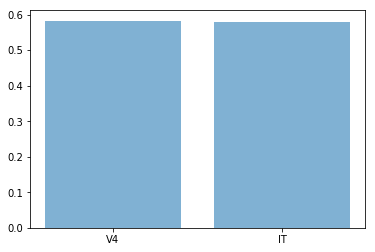

V4 explanation: ['fire5/concat', 'fire4/concat', 'fire3/concat', 'fire2/concat', 'pool1']
IT explanation: ['relu_conv10', 'fire9/concat', 'fire8/concat', 'fire7/concat', 'fire6/concat']


In [10]:
run(model='squeezenet', layers=['pool1', 'fire2/concat', 'fire3/concat', 'fire4/concat', 
                                'fire5/concat', 'fire6/concat', 'fire7/concat', 'fire8/concat', 
                                'fire9/concat', 'relu_conv10'])

### DenseNet

In [12]:
run(model='densenet', layers=['activation_1', 'activation_4', 'activation_7', 'activation_10', 'activation_13', 
                              'activation_16', 'activation_19', 'activation_22', 'activation_25', 'activation_28', 
                              'activation_31', 'activation_34', 'activation_37', 'activation_40', 'activation_43', 
                              'activation_46', 'activation_49', 'activation_52', 'activation_55', 'activation_58', 
                              'activation_61', 'activation_64', 'activation_67', 'activation_70', 'activation_73', 
                              'activation_76', 'activation_79', 'activation_82', 'activation_85', 'activation_88', 
                              'activation_91', 'activation_94', 'activation_97', 'activation_100', 'activation_103', 
                              'activation_106', 'activation_109', 'activation_112', 'activation_115', 'activation_118', 
                              'activation_121'])

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/densenet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


ValueError: Operation 'IsVariableInitialized_1480' has been marked as not fetchable.

### MobileNet

In [13]:
run(model='mobilenet', layers=['conv1_relu', 'conv_dw_1_relu', 'conv_pw_1_relu', 
                               'conv_dw_2_relu', 'conv_pw_2_relu', 
                               'conv_dw_3_relu', 'conv_pw_3_relu', 
                               'conv_dw_4_relu', 'conv_pw_4_relu', 
                               'conv_dw_5_relu', 'conv_pw_5_relu', 
                               'conv_dw_6_relu', 'conv_pw_6_relu', 
                               'conv_dw_7_relu', 'conv_pw_7_relu', 
                               'conv_dw_8_relu', 'conv_pw_8_relu', 
                               'conv_dw_9_relu', 'conv_pw_9_relu', 
                               'conv_dw_10_relu', 'conv_pw_10_relu', 
                               'conv_dw_11_relu', 'conv_pw_11_relu', 
                               'conv_dw_12_relu', 'conv_pw_12_relu', 
                               'conv_dw_13_relu', 'conv_pw_13_relu', 
                               'global_average_pooling2d_1', 'act_softmax'])

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/mobilenet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


ValueError: Operation 'IsVariableInitialized_3109' has been marked as not fetchable.